# How you can drive safely in 2020


### Use LR/KNN/Decision Tree/Random Forest classification algorithms from sklearn to predict the accident severity

Due to the limit of computer capacity, I am focusing on the State of New York. I will only select a few features I believe are more relavant to severity. Categorical data will be treated with Pandas get_dummies method. Rows with missing values will be dropped.

### Data source
https://www.kaggle.com/sobhanmoosavi/us-accidents


### Acknowledgements

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.


####  Author
Ronghui Zhou, zhou.uf@gmail.com
https://github.com/RonghuiZhou

### Step 1. Import libraries

In [1]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

### Step 2. Import the dataset

In [2]:
# Import the data
df = pd.read_csv('./US_Accidents_May19.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243939 entries, 0 to 2243938
Data columns (total 49 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 int64
Start_Time               object
End_Time                 object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi

### Step 3. Extract year, month, day, hour, weekday, and time to clear accidents

In [3]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243939 entries, 0 to 2243938
Data columns (total 55 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 int64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float

### Step 4. Deal with outliers

#### A. Drop rows with severity-0

In [4]:
df=df[df.Severity != 0]

### Step 4. Deal with outliers

#### B. Drop rows with negative time_duration

In [5]:
# Check if there is any negative time_duration values
df[td][df[td]<=0]

69720      -0.0
69721      -0.0
69722      -0.0
69723      -1.0
69724      -1.0
309389    -30.0
309390    -30.0
746173    -30.0
746174    -31.0
1482940   -30.0
1483025   -30.0
1483026   -31.0
2038017   -31.0
Name: Time_Duration(min), dtype: float64

In [6]:
# Drop the rows with td<0

neg_outliers=df[td]<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Drop rows with negative td
df.dropna(subset=[td],axis=0,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243909 entries, 0 to 2243938
Data columns (total 55 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 float64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             flo

In [7]:
# Double check to make sure no more negative td
df[td][df[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

### Step 4. Deal with outliers

#### C. Fill outliers with median values

In [8]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243909 entries, 0 to 2243938
Data columns (total 55 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 float64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             flo

In [9]:
# Print time_duration information
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident td: {} minutes.'.format(df[td].max(),round(df[td].max()/60), round(df[td].max()/60/24), df[td].min()))

Max time to clear an accident: 12424.0 minutes or 207 hours or 9 days; Min to clear an accident td: 1.0 minutes.


In [10]:
# Export the data
# df.to_csv('./US_Accidents_May19_clean.csv',index=False)

### Step 5. Select a list of features for machine learning algorithms

 Only select relavant columns without overwhelming the computer

In [11]:
# Set the list of features to include in Machine Learning
feature_lst=['Source','TMC','Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']

In [12]:
# Select the dataset to include only the selected features
df_sel=df[feature_lst].copy()
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243909 entries, 0 to 2243938
Data columns (total 34 columns):
Source                object
TMC                   float64
Severity              float64
Start_Lng             float64
Start_Lat             float64
Distance(mi)          float64
Side                  object
City                  object
County                object
State                 object
Timezone              object
Temperature(F)        float64
Humidity(%)           float64
Pressure(in)          float64
Visibility(mi)        float64
Wind_Direction        object
Weather_Condition     object
Amenity               float64
Bump                  float64
Crossing              float64
Give_Way              float64
Junction              float64
No_Exit               float64
Railway               float64
Roundabout            float64
Station               float64
Stop                  float64
Traffic_Calming       float64
Traffic_Signal        float64
Turning_Loop          flo

In [13]:
# Export the data with selected features
# df_sel.to_csv('./US_Accidents_May19_clean_sel.csv',index=False)

### Step 6. Drop rows with missing values

In [14]:
# Check missing values
df_sel.isnull().mean()

Source                0.000217
TMC                   0.230303
Severity              0.000217
Start_Lng             0.000217
Start_Lat             0.000217
Distance(mi)          0.000217
Side                  0.000217
City                  0.000248
County                0.000217
State                 0.000217
Timezone              0.001172
Temperature(F)        0.027944
Humidity(%)           0.028925
Pressure(in)          0.025724
Visibility(mi)        0.031998
Wind_Direction        0.021230
Weather_Condition     0.032285
Amenity               0.000217
Bump                  0.000217
Crossing              0.000217
Give_Way              0.000217
Junction              0.000217
No_Exit               0.000217
Railway               0.000217
Roundabout            0.000217
Station               0.000217
Stop                  0.000217
Traffic_Calming       0.000217
Traffic_Signal        0.000217
Turning_Loop          0.000217
Sunrise_Sunset        0.000252
Hour                  0.000217
Weekday 

In [15]:
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(1663614, 34)

In [16]:
# Export the data with selected features
# df_sel.to_csv('./US_Accidents_May19_clean_sel_dropna.csv',index=False)

### Step 7. Select the state of interest: NY
     

Due to the limitation of personal laptop, the whole US dataset is too big to handle

In [17]:
# Import data if it was already exported based on previous work
# df_sel=pd.read_csv('./US_Accidents_May19_clean_sel_dropna.csv')

In [18]:
# Set state
state='NY'

# Select the state of Pennsylvania
df_state=df_sel.loc[df_sel.State==state]
df_state.drop('State',axis=1, inplace=True)
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80119 entries, 194256 to 1724935
Data columns (total 33 columns):
Source                80119 non-null object
TMC                   80119 non-null float64
Severity              80119 non-null float64
Start_Lng             80119 non-null float64
Start_Lat             80119 non-null float64
Distance(mi)          80119 non-null float64
Side                  80119 non-null object
City                  80119 non-null object
County                80119 non-null object
Timezone              80119 non-null object
Temperature(F)        80119 non-null float64
Humidity(%)           80119 non-null float64
Pressure(in)          80119 non-null float64
Visibility(mi)        80119 non-null float64
Wind_Direction        80119 non-null object
Weather_Condition     80119 non-null object
Amenity               80119 non-null float64
Bump                  80119 non-null float64
Crossing              80119 non-null float64
Give_Way              80119 non-null

C:\Users\rzhou11\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
# Check how many groups of severity and the number of accidents in each group 
df_state.Severity.value_counts().sort_values(ascending=False)

2.0    44002
3.0    36056
4.0       42
1.0       19
Name: Severity, dtype: int64

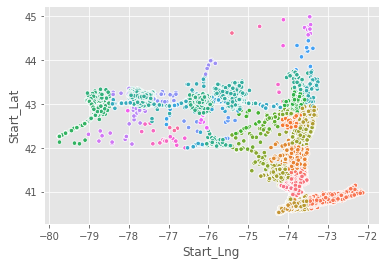

In [20]:
# Map of accidents, color code by county

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20)
plt.show()

### Step 8. Deal with categorical data: pd.get_dummies()


In [21]:
# Generate dummies for categorical data
df_state_dummy = pd.get_dummies(df_state,drop_first=True)

# Export data
df_state_dummy.to_csv('./US_Accidents_May19_{}_dummy.csv'.format(state),index=False)

df_state_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80119 entries, 194256 to 1724935
Columns: 991 entries, TMC to Weekday_Wed
dtypes: float64(24), uint8(967)
memory usage: 89.2 MB


### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Data preparation: train_test_split

In [22]:
# Assign the data
df=df_state_dummy


# Set the target for the prediction
target='Severity'



# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

In [23]:
y.unique()

array([3., 2., 4., 1.])

In [24]:
y.value_counts()

2.0    44002
3.0    36056
4.0       42
1.0       19
Name: Severity, dtype: int64

In [25]:
# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [26]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm A. Logistic regression              

In [27]:
# Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

C:\Users\rzhou11\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rzhou11\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[Logistic regression algorithm] accuracy_score: 0.839.


C:\Users\rzhou11\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### KNN with 6 neighors

In [28]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

[K-Nearest Neighbors (KNN)] knn.score: 0.636.
[K-Nearest Neighbors (KNN)] accuracy_score: 0.636.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### Optmize the number of neighors: plot the accuracy versus number of neighbors

# Skip this cell


# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a k-NN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()



### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm C. Decision Tree                 

In [32]:
# Decision tree algorithm

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))

[Decision Tree -- entropy] accuracy_score: 0.738.
[Decision Tree -- gini] accuracy_score: 0.742.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### n_estimators=100                 

In [33]:
# Random Forest algorithm

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)


# Model Accuracy, how often is the classifier correct?
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))


[Randon forest algorithm] accuracy_score: 0.896.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### Visualize important features      

No handles with labels found to put in legend.


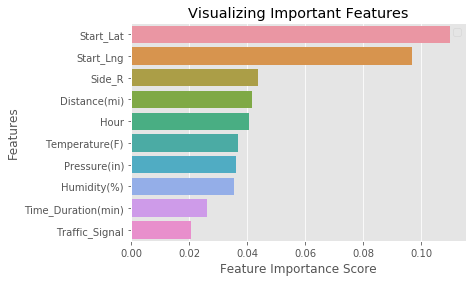

In [34]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [35]:
# List top k important features
k=20
feature_imp.sort_values(ascending=False)[:k]

Start_Lat             0.109805
Start_Lng             0.096891
Side_R                0.043788
Distance(mi)          0.041580
Hour                  0.040546
Temperature(F)        0.036880
Pressure(in)          0.036074
Humidity(%)           0.035645
Time_Duration(min)    0.026018
Traffic_Signal        0.020708
TMC                   0.017617
County_Monroe         0.016261
City_Albany           0.014394
Visibility(mi)        0.012798
County_Suffolk        0.011288
City_Bronx            0.009678
County_Erie           0.009517
County_Bronx          0.008838
City_Rochester        0.008729
County_Nassau         0.008596
dtype: float64

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### Select the top important features, set the threshold      

In [36]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Start_Lng
Start_Lat
Distance(mi)
Temperature(F)
Humidity(%)
Pressure(in)
Hour
Side_R


In [37]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [38]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

[Randon forest algorithm -- Full feature] accuracy_score: 0.896.
[Randon forest algorithm -- Limited feature] accuracy_score: 0.883.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Plot the accuracy score versus algorithm

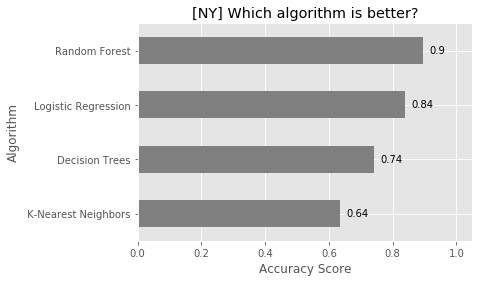

In [39]:
# Make a plot of the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Export to a file
df_acc.to_csv('./Accuracy_scores_algorithms_{}.csv'.format(state),index=False)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,1.05)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('[{}] Which algorithm is better?'.format(state))

plt.show()